Loading modules

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

Loading text

In [2]:
f = open('New Text Document.txt')
l = f.readlines()
f.close()


In [4]:
print(len(l))

24


Text contains 24 paragraphs . Data needs to be cleaned. That read data is cleaned and stored in 'data2'.

In [5]:
data2 = []
for i in l:
    a = []
    temp = i.strip()
    word = ''
    j = 0
    while j<len(temp):
        if temp[j]==' ':
            a.append(word.lower())
            word = ''
        elif temp[j] in ['?',',','"','!',')','(','.']:
            if word != '':
                a.append(word.lower())
            a.append(temp[j])
            word = ''
            
        else:
            word += temp[j]
        j +=1 
    if len(word) != 0:
        a.append(word.lower())
    if a[-1] != '\n':
        a.append('\n')
    data2.append(a)

In [6]:
data2

[['internet',
  'can',
  'be',
  'reckoned',
  'as',
  'the',
  'latest',
  'discovery',
  'of',
  'man',
  'which',
  'has',
  'revolutionised',
  'his',
  'style',
  'of',
  'working',
  'and',
  'living',
  '.',
  '',
  'it',
  'has',
  'totally',
  'reduced',
  'distance',
  ',',
  '',
  'broken',
  'all',
  'man-made',
  'barriers',
  'and',
  'made',
  'our',
  'world',
  'a',
  'small',
  'place',
  '.',
  '',
  'it',
  'brought',
  'information',
  'at',
  'our',
  'doorstep',
  'opening',
  'before',
  'us',
  'what',
  'is',
  'known',
  'as',
  'information',
  'superhighway',
  'at',
  'the',
  'click',
  'of',
  'a',
  'button',
  '.',
  '\n'],
 ['internet',
  'is',
  'a',
  'network',
  'of',
  'computer',
  'systems',
  'that',
  'have',
  'been',
  'connected',
  'to',
  'each',
  'other',
  'through',
  'satellite',
  ',',
  '',
  'telephone',
  'lines',
  'and',
  'optical',
  'cables',
  '.',
  '',
  'basically',
  'internet',
  'is',
  'a',
  'global',
  'electronic

Creating word dictionary . 'word_dict2' has words as keys and index as values. Whereas , 'rev_word_dict2' has words as values

In [7]:
word_dict2 = {}
index = 0
for i in data2:
    for j in i:
        if j not in word_dict2:
            word_dict2[j] = index
            index+=1
rev_word_dict2 = {}
for i in word_dict2:
    rev_word_dict2[word_dict2[i]] = i

In [8]:
len(word_dict2)

478

'word_dict2' has length 478. That means , text consists of 478 distinct words 

'encodings2' is a helper function that takes sentence as parameter and returns encoded sentence. i.e, each word is replaced with its word vector 

It basically returns one hot encoding of sentence.

In [16]:
def encodings2(sentence,word_dict2):
    vocab_size = len(word_dict2)
    input_size = len(sentence)
    one_hot_sentence = torch.zeros([input_size-1],dtype=torch.long)
    target = torch.zeros([input_size-1],dtype=torch.long)

    for i in range(len(sentence)-1):
        word = sentence[i]
        next_word = sentence[i+1]
        one_hot_sentence[i] = word_dict2[word]
        target[i] = word_dict2[next_word]
    #print(one_hot_sentence.shape,target.shape)
    return(one_hot_sentence,target)

### Creating model

model 'RNN' has LSTM units

In [138]:
class RNN(nn.Module):
    def __init__(self,hidden_size,output_size,vocab_size,embedding,num_layers):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.emb = embedding
        self.embedding = nn.Embedding(vocab_size,embedding)
        self.lstm = nn.LSTM(embedding,hidden_size,batch_first=True,num_layers=num_layers)
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(hidden_size,output_size)
    def forward(self,x,hidden,cell):
        x = self.embedding(x)
        x = x.reshape(1,x.shape[0],x.shape[1])
        x,(hidden,cell) = self.lstm(x,(hidden,cell))
        x = self.dropout(x)
        x = self.fc(x)
        return(x,(hidden,cell))
    def initHidden(self):
        return(torch.zeros([self.num_layers,1,self.hidden_size]))

In [139]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Some hyperparameters

In [149]:
embedding = 40
output_size = vocab_size = len(word_dict2)
hidden_size = 64
num_layers = 3
learning_rate = 0.01
epochs = 64

Model initialization

In [150]:
model2 = RNN(hidden_size,output_size,vocab_size,embedding,num_layers).to(device)
optimizer = optim.Adam(model2.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

### Training 

In [151]:
loss_lst = []
for epoch in range(epochs):
    epoch_loss = []
    t1 = time.time()
    for sentence in data2:
        
        sentence_encoding,target = encodings2(sentence,word_dict2)
        sentence_encoding = sentence_encoding.to(device)
        target = target.to(device)
        #print(sentence_encoding)
        #print(target.shape)
        hidden = model2.initHidden().to(device)
        cell = model2.initHidden().to(device)
        #print(cell.shape)
        model2.zero_grad()
        optimizer.zero_grad()

        out,(hidden,cell) = model2(sentence_encoding,hidden,cell)
        #print(out.shape)
        out = out.reshape(-1,output_size)
        loss = criterion(out,target)
        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    loss_lst += epoch_loss
    t2 = time.time()
    print("mean epoch loss : {}  ||  mean loss till now : {}  ||  time : {}".format(np.mean(epoch_loss),np.mean(loss_lst),t2-t1))

mean epoch loss : 5.683175563812256  ||  mean loss till now : 5.683175563812256  ||  time : 0.2577850818634033
mean epoch loss : 5.221380392710368  ||  mean loss till now : 5.4522779782613116  ||  time : 0.21968960762023926
mean epoch loss : 5.073023200035095  ||  mean loss till now : 5.325859718852573  ||  time : 0.2006239891052246
mean epoch loss : 4.901444435119629  ||  mean loss till now : 5.219755897919337  ||  time : 0.21622586250305176
mean epoch loss : 4.706168780724208  ||  mean loss till now : 5.117038474480311  ||  time : 0.2312309741973877
mean epoch loss : 4.58610784014066  ||  mean loss till now : 5.028550035423702  ||  time : 0.261394739151001
mean epoch loss : 4.493608891963959  ||  mean loss till now : 4.952129872072311  ||  time : 0.2415482997894287
mean epoch loss : 4.438963870207469  ||  mean loss till now : 4.887984121839206  ||  time : 0.21890544891357422
mean epoch loss : 4.265180180470149  ||  mean loss till now : 4.81878368390931  ||  time : 0.19721055030822754

For LSTM loss converges till 0.3 in 80 epochs consuming 0.3 sec per epoch
For GRU loss converges till 0.3 in 25 epochs consuming 0.2 sec per epoch
For RNN loss converges till 0.2 in 25 epochs consuming 0.2 sec per epoch

Plotting loss function

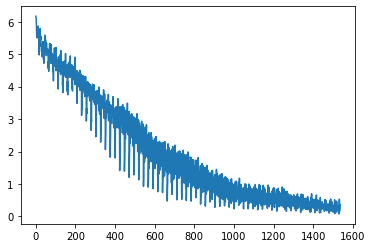

In [152]:
plt.plot(loss_lst)

In [160]:
torch.save(model2.state_dict(),'wordRNN_paragraph_lstm.pth')

### If you dont wanna train model , you can run followinf cell to load pretrained model

In [146]:
model2.load_state_dict(torch.load('wordRNN_paragraph_lstm.pth'))
#embedding = 40 output_size = vocab_size = len(word_dict2)  hidden_size = 64 num_layers = 3
#learning_rate = 0.01  epochs = 64

<All keys matched successfully>

In [130]:
model2.load_state_dict(torch.load('wordRNN_paragraph_gru.pth'))
#embedding = 32 output_size = vocab_size = len(word_dict2) hidden_size = 64 num_layers = 2
#learning_rate = 0.01 epochs = 25

<All keys matched successfully>

In [122]:
model2.load_state_dict(torch.load('wordRNN_paragraph_rnn.pth'))
#embedding = 32 output_size = vocab_size = len(word_dict2) hidden_size = 64 num_layers = 2
#learning_rate = 0.01 epochs = 25

<All keys matched successfully>

### Testing model

In [153]:
def testing2(sentence):
    sentence = sentence.strip()
    sample = sentence
    word = sentence.split()[-1]
    word_encoding = torch.tensor([word_dict2[word]]).to(device)
    

    if len(sentence.split()) >= 2:
        if len(sentence.split()) == 2:
            sentence_encoding = torch.tensor([word_dict2[sentence.split()[0]]]).to(device)
        else:
            sentence_encoding,target = encodings2(sentence.split()[:-1],word_dict2)
        hidden = model2.initHidden().to(device)
        cell = model2.initHidden().to(device)
        out,(hidden,cell) = model2(sentence_encoding.to(device),hidden,cell)
    
    else:
        hidden = model2.initHidden().to(device)
        cell = model2.initHidden().to(device)
    i=0
    while word != '\n':    
        out,(hidden,cell) = model2(word_encoding,hidden,cell)
        #out = torch.zeros()
        word_index = out.argmax(axis=-1).item()
        word = rev_word_dict2[word_index]
        word_encoding = out.argmax(axis=-1).flatten()
        sample = "{} {}".format(sample,word)
        #print(word)
        i+=1
        if i==60:
            break
    
        
    
    return(sample)

GRU

In [106]:
testing2('we are living in information')

'we are living in information from storage areas of the servers called websites .  today we can get any information on any topic in a matter of seconds . \n'

In [132]:
testing2('today')

'today every nook and corner of the world our through .  and with the speed ,  we are becoming addict to it a day in will come when it will become our basic necessity . \n'

In [131]:
testing2('internet is')

'internet is a great tool which man has invented .  its potential is still not fully .  more and more uses of internet are being discovered as days go by . \n'

RNN

In [117]:
testing2('we are living in information')

'we are living in information any topic in seconds . \n'

In [118]:
testing2('today')

'today every nook and corner of the world .  also ,  these things cause trouble for oneself and others too . \n'

In [119]:
testing2('internet is')

'internet is a great tool which man has invented .  its potential is still not fully tapped .  have become quite common now- a-days . \n'

LSTM

In [157]:
testing2('we are living in information')

'we are living in information other used but also .  it has provided an exciting and internet addiction .  basically internet is a global electronic community for millions of interconnected computer networks . \n'

In [158]:
testing2('today')

'today every nook and corner of the world has made a long journey .  also ,  during this journey ,  the internet has adopted many things ,  highly fast ,  cheap ,  safe ,  and least cumbersome . \n'

In [159]:
testing2('internet is')

'internet is a great tool which man has invented .  its potential is still not fully tapped .  more and more uses of internet are being discovered as days go by . \n'